In [2]:
# for numbers
import xarray as xr
import numpy as np
import pandas as pd

# for figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# Description of this code

We define a function called `quick_map` that is a convenience function. It needs the longitude and latitude meshes and the array of data to map. The key word argument `title` can be supplied to put a title on the map. The `**kwargs` is a dictionary of optional key word arguments that get passed into `pcolormesh`. The map defaults to the Robinson projection; we can change this if there is a projection that we like better. The colormap is not specified, so it will default, if you want to specify one, just include `cmap` in the `kwargs` dict.

The code then loads the event statistics for observations and models (2 separate files), and gets the event ID numbers (lat, lon, event).

The first figures then just make the maps of total number of events.

Then we start to explore ways to divide the events by time (e.g., by month.) I'm still working on this part.

In [3]:
def quick_map(lons, lats, data, title=None, **kwargs):
    f, a = plt.subplots(subplot_kw={"projection":ccrs.Robinson()})
    # pass in norm as kwarg if needed
    # norm = mpl.colors.Normalize(vmin=1979, vmax=2019)
    img = a.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), **kwargs)
    a.set_title(title)
    f.colorbar(img, shrink=0.4)
    return f, a

# Quick events stats
In the `event_attributes_compressed` files, we have `Event_ID`, `initial_index`, and `duration`. These are useful for doing basic statistics of the events (defined with the 90th percentile TMAX). 

Next, we load these files, and map the total number of events.

In [4]:
stem = "/project/amp/brianpm/TemperatureExtremes/Derived/"
obsfil = "CPC_tmax_90pct_event_attributes_compressed.nc"
mdlfil = "f.e13.FAMIPC5CN.ne30_ne30.beta17.TREFMXAV.90pct_event_attributes_compressed.nc"
obs_ds = xr.open_dataset(stem+obsfil)
mdl_ds = xr.open_dataset(stem+mdlfil)

In [5]:
obs_ids = obs_ds['Event_ID']  # each point has a series of events that are labeled as increasing integers
mdl_ids = mdl_ds['Event_ID']

In [6]:
# number of events:
obs_nevents = obs_ids.max(dim='events')
mdl_nevents = mdl_ids.max(dim='events')

In [7]:
lons, lats = np.meshgrid(mdl_ds['lon'], mdl_ds['lat'])

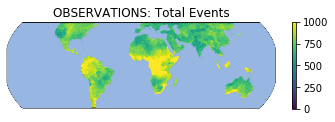

In [8]:
# plot of number of events
norm = mpl.colors.Normalize(vmin=0, vmax=1000.)
res = {'norm':norm}
fig1, ax1 = quick_map(lons, lats, obs_nevents, title="OBSERVATIONS: Total Events", **res)
ax1.add_feature(cartopy.feature.OCEAN, zorder=100)
ax1.set_extent([-180, 180,-60, 60])

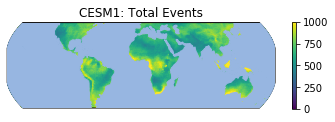

In [9]:
fig2, ax2 = quick_map(lons, lats, mdl_nevents, title="CESM1: Total Events", **res)
ax2.add_feature(cartopy.feature.OCEAN, zorder=100)
ax2.set_extent([-180, 180,-60, 60])

# Events divided by month

We have the index of each event, but not the actual time. Here we show how to retrieve the actual dates of events. 


In [10]:
# original data:
obs_data = xr.open_mfdataset("/project/amp/jcaron/CPC_Tminmax/tmax.*.nc", combine='by_coords')

In [11]:
%%time
time = obs_data['time'].compute()

CPU times: user 238 µs, sys: 89 µs, total: 327 µs
Wall time: 342 µs


In [15]:
def get_event_dates(time_coord, init, dur):
    start_date = time_coord[init]
    finish_date = time_coord[init+dur]
    return start_date, finish_date

In [30]:
s = obs_ids[:, 100, 100]
x = obs_ds['initial_index'][:,100,100]
d = obs_ds['duration'][:,100,100]


for i, event in enumerate(s):
#     print(i)
    if event == 0:
        continue
    else:
        initial = x[i].astype(int)
        duration = d[i].astype(int)
        st, fn = get_event_dates(time, initial, duration)
        print(f"start: {st.values}, end: {fn.values}")

start: 1979-01-01T00:00:00.000000000, end: 1979-01-03T00:00:00.000000000
start: 1979-02-05T00:00:00.000000000, end: 1979-02-09T00:00:00.000000000
start: 1979-02-14T00:00:00.000000000, end: 1979-02-17T00:00:00.000000000
start: 1979-03-11T00:00:00.000000000, end: 1979-03-12T00:00:00.000000000
start: 1979-03-15T00:00:00.000000000, end: 1979-03-17T00:00:00.000000000
start: 1979-03-18T00:00:00.000000000, end: 1979-03-22T00:00:00.000000000
start: 1979-04-04T00:00:00.000000000, end: 1979-04-05T00:00:00.000000000
start: 1979-04-10T00:00:00.000000000, end: 1979-04-11T00:00:00.000000000
start: 1979-05-10T00:00:00.000000000, end: 1979-05-11T00:00:00.000000000
start: 1979-05-12T00:00:00.000000000, end: 1979-05-13T00:00:00.000000000
start: 1979-05-22T00:00:00.000000000, end: 1979-05-23T00:00:00.000000000
start: 1979-08-13T00:00:00.000000000, end: 1979-08-15T00:00:00.000000000
start: 1979-08-28T00:00:00.000000000, end: 1979-08-31T00:00:00.000000000
start: 1979-09-01T00:00:00.000000000, end: 1979-09-

Now the issue is that we'd like to do this for every event.

Since we already have duration, we really just need the starting time for each event at each location. We should write this when we first calculate the attributes.

In [36]:
# stack spatial points so only 1-d
obs_stack = obs_ds.stack(z=("lat","lon")) 

In [41]:
obs_stack

<xarray.Dataset>
Dimensions:        (events: 1202, z: 259200)
Coordinates:
  * events         (events) int64 1 2 3 4 5 6 ... 1197 1198 1199 1200 1201 1202
  * z              (z) MultiIndex
  - lat            (z) float64 89.75 89.75 89.75 89.75 ... -89.75 -89.75 -89.75
  - lon            (z) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
Data variables:
    Event_ID       (events, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    initial_index  (events, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    duration       (events, z) float64 1.474e+04 1.474e+04 1.474e+04 ... 0.0 0.0

In [ ]:
%%time
stdata = np.zeros(obs_stack['Event_ID'].shape, dtype='datetime64[s]')
print(stdata.shape)
for j in range(len(obs_stack.events)):
    print(f"Working on event {j}")
    for i in range(len(obs_stack.z)):
        if obs_stack["Event_ID"][j, i].max() <= 0:
            stdata[j, i] = '0000-01-01'  # missing
        else:
            ndx = obs_stack['initial_index'][j, i].astype(int).item()
            stdata[j, i] = time[ndx].values


(1202, 259200)
Working on event 0
Working on event 1
Working on event 2
Working on event 3
Working on event 4
Working on event 5
Working on event 6
Working on event 7
Working on event 8
Working on event 9
Working on event 10
Working on event 11
Working on event 12
Working on event 13
Working on event 14
Working on event 15
Working on event 16
Working on event 17
Working on event 18
Working on event 19
Working on event 20
Working on event 21
Working on event 22
Working on event 23
Working on event 24
Working on event 25
Working on event 26
Working on event 27
Working on event 28
Working on event 29
Working on event 30
Working on event 31
Working on event 32
Working on event 33
Working on event 34
Working on event 35
Working on event 36
Working on event 37
Working on event 38
Working on event 39
Working on event 40
Working on event 41
Working on event 42
Working on event 43
Working on event 44
Working on event 45
Working on event 46
Working on event 47
Working on event 48
Working on even

In [85]:
start_time = xr.DataArray(stdata, coords=obs_stack.coords, dims=obs_stack.dims)

0

In [94]:
time[9].values

numpy.datetime64('1979-01-10T00:00:00.000000000')

In [32]:
print(obs_event_fil['time'].min())
print(obs_event_fil['time'].max())
print(mdl_event_fil['time'].min())
print(mdl_event_fil['time'].max())

<xarray.DataArray 'time' ()>
array('1979-01-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()>
array('2019-05-06T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1965, 1, 1, 0, 0, 0, 0, 5, 1), dtype=object)
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, 4, 1), dtype=object)


In [46]:
tt = np.array([time[1000].values])


AttributeError: 'numpy.datetime64' object has no attribute 'dt'